## 4. CNN *vs* RNN Prediciendo el Ozono Atmosférico
---

En esta actividad utilizaremos redes neuronales para predicción de series de tiempo. Dada una serie de registros del valor de una variable en el tiempo (serie de tiempo) nos interesa entrenar un modelo que pueda predecir los valores futuros de la misma serie. 

En este caso, la serie corresponde a las concentraciones diarias (máximas) de $O_3$ medidas en la comuna de Las Condes entre Diciembre de 2003 y Diciembre de 2016. El $O_3$ (a nivel respirable) es un contaminante con graves efectos sobre la salud humana y sobre la agricultura, por lo que monitorear y predecir sus concentraciones en el tiempo es de gran relevancia. Se sabe que el $0_3$ alcanza sus niveles máximos en verano, por lo que estudiaremos sólo esos períodos. Esto hace que la serie que usted recibirá no es totalmente continua en el tiempo en el sentido de que los registros se miden hasta marzo de un año y se reinician en noviembre de ese mismo año. **Por favor considere atentamente esta situación.**   

El archivo *CSV* que usted recibirá tiene las siguientes columnas 

[‘registered_on’, ‘CO', 'PM10', 'PM25', 'NO', 'NOX', 'WD', 'RH', 'TEMP', 'WS', 'UVA', 'UVB', 'O3']

El primero corresponde a la fecha del registro. La última columna corresponde a la variable que queremos predecir y las demás son mediciones de otros contaminantes y de variables meteorológicas que podrían ayudar a predecir los niveles de $O_3$.  

Su tarea consistirá en entrenar una red capaz de predecir los niveles de ozono el día de mañana sólo partir de los niveles *previas* de ozono y demás variables. Para ésto pre-procesaremos los datos, cada contaminante tendrá su serie de tiempo y asociada con las otras. Con ésto deberemos generar *secuencias de entrenamiento*, recordar que cada secuencia estará asocaida a un *Target* que es el $O_3$ del día siguiente.

Compararemos y aplicaremos redes convolucionales uni-dimensionales y redes neuronales recurrentes, las cuales se adaptan perfectamente a escenarios de secuencias ya que modelan que el estado actual se genera a partir del estado anterior (como en una cadena de Markov).

En primer lugar carge el *csv* en un dataframe de pandas 

a) Explore los datos y visualícelos, ya sea a través de medidas de tendencia o gráficos. Lo primero que deberá realizar será crear su conjunto de validación/test a partir de los datos, por ejemplo las últimas mediciones puesto que la tarea será predecir los datos futuros (*out of box*). Además escale los datos apropiadamente.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


In [3]:
df = pd.read_csv('./ozone_data.csv')
df.describe()

,CO,PM10,PM25,NO,NOX,WD,RH,TEMP,WS,UVA,UVB,O3
count,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000
mean,0.185423,0.129600,0.118716,0.078096,0.143159,0.688165,0.715321,0.552156,0.158919,0.032180,0.033077,0.415092
std,0.084199,0.064871,0.062701,0.062492,0.085842,0.082069,0.140079,0.132291,0.090008,0.031261,0.025226,0.127287
min,0.000000,0.011780,0.003745,0.000147,0.008587,0.000000,0.155555,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.137931,0.094241,0.082397,0.039211,0.091954,0.643123,0.618888,0.482512,0.128617,0.023690,0.028463,0.335329
50%,0.172413,0.117801,0.108614,0.067740,0.130622,0.663091,0.724444,0.569956,0.143259,0.030190,0.034660,0.413174
75%,0.226612,0.148560,0.142322,0.099501,0.169170,0.698589,0.824444,0.636792,0.159043,0.034680,0.037717,0.496634
max,0.700110,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.910180


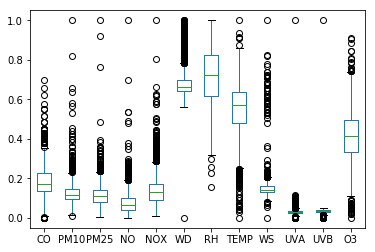

In [4]:
df.boxplot(grid=False)

Se ve que existen muchos outliers en las columnas, y que las distintas columnas tienen un rango de valores similar, entre 0 y 1, además las concentraciónes de los datos para cada carácterística varían, los datos centrales de las primeras 5 carácterísticas tienen intervalos cercanos, a diferencia del resto que estan más dispersos. Existen datos con claros errores de medición, ya que la concentración no puede llegar a ser 1, por lo que creemos que hay valores que si se podrían sacar del conjunto.

Luego, se separa un conjunto de pruebas y se escalan los valores:
Primero se realiza la separación de los conjuntos y luego su escalamiento.

In [5]:
x_test, x_train = train_test_split(df.values[:,1:], test_size=0.33)
mms = MinMaxScaler()
mms.fit(x_train)
x_train_norm = mms.transform(x_train)

ozono = df['O3'].values.reshape(-1,1)
mms = MinMaxScaler()
mms.fit(ozono)
ozono_norm = mms.transform(ozono).reshape(1,-1)[0]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


b) Ahora nos gustarı́a manipular los datos, para que hagamos la predicción para el tiempo siguiente usando los valores de los últimos perı́odos de tiempo. El número de perı́odos de tiempos "hacia atrás" que usaremos se denomina *lag*. Por ejemplo, tendremos un *lag* igual a 3, si para predecir el valor $x_{t+1}$ en el tiempo siguiente usamos la información del tiempo actual $x_t$ y la de los dos perı́odos anteriores $x_{t-1}$ y $x_{t-2}$ como variables de entrada. Realice una función que reciba una secuencia de valores y la transforme en dos arreglos *dataX* (inputs) y *dataY* (targets), además utilicela para generar los conjuntos de entrenamiento y test para el problema decidiendo el valor del *lag*.

In [0]:
def create_dataset(dataset,lag=1):
    dataX = [dataset[i:i+lag] for i in range(len(dataset)-lag)]
    dataY = [dataset[i] for i in range(lag, len(dataset))]
    return np.array(dataX), np.array(dataY)

In [0]:
originalTrain = ozono_norm[:1400]
originalTest = ozono_norm[1400:]

lag = 6

def train_test_sets(lag):
    trainX, trainY = create_dataset(ozono_norm[:1400], lag)
    testX, testY = create_dataset(ozono_norm[1400:], lag)
    return trainX, testX, trainY, testY

trainX, testX, trainY, testY = train_test_sets(lag)

Primero definimos la función "create_dataset" que entrega dos arreglos con los datos que segun el lag se van a usar para predecir el siguiente valor de Y. la siguiente función repite este proceso pero para dos conjuntos, el de testeo y el de entrenamiento.

c) En estos momentos tenemos nuestros datos en la forma [*samples, features*]. Sin embargo, la red RNN necesita que los datos se encuentren en un arreglo de tres dimensiones [*samples, time steps, features*]. Transforme el  conjuntos de entrenamiento y de pruebas a la estructura deseada, incorporando el *lag* como *features*. Defina dos modelos para comparar, una red recurrente simple y una red convolucional unidimensional (donde el kernel es un vector de largo $w$), comente sobre las dimensiones/*shape* de los parámetros de cada una de las redes. Entrene los dos modelos con la nueva representación ¿Qué limitaciones tiene el tamaño/*width* del kernel de la convolucional?.

In [0]:
testX_c = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX_c = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [0]:
def train_rnn(x, y, shape, v=1):
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(units=4, input_shape=shape, activation='tanh', 
                            return_sequences=False, go_backwards=False))
    model_rnn.add(Dense(1,activation='linear'))
    model_rnn.compile(loss='mean_squared_error', optimizer='adam')
    if v==1:
        model_rnn.summary()
    rnn_weights = model_rnn.get_weights()
    model_rnn.fit(x, y, epochs=25, batch_size=1, verbose=v)
    
    return model_rnn

In [10]:
model_rnn = train_rnn(trainX_c, trainY, (1,lag))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 44        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
1394/1394 [==============================] - 5s 4ms/step - loss: 0.0943
Epoch 2/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0202
Epoch 3/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0178
Epoch 4/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0168
Epoch 5/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0160
Epoch 6

In [0]:
def train_cnn(x, y, shape, v=1):

    model_cnn = Sequential()
    model_cnn.add(Conv1D(4, kernel_size=1, input_shape=shape,
                         activation='relu', padding='valid')) 
    model_cnn.add(Flatten())
    model_cnn.add(Dense(1,activation='linear'))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam')
    if v==1:
        model_rnn.summary()
    cnn_weights = model_cnn.get_weights()
    model_cnn.fit(x, y, epochs=25, batch_size=1, verbose=v)
    
    return model_cnn

In [12]:
model_cnn = train_cnn(trainX_c, trainY, (1,lag))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 44        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1394/1394 [==============================] - 7s 5ms/step - loss: 0.0196
Epoch 2/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0160
Epoch 3/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0151
Epoch 4/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0151
Epoch 5/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0151
Epoch 6/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0151
Epoch 7/25
1394/1394 [======================

El tamaño (width) si es muy grande pierde la capacidad de detectar características sutiles de los datos. Además debido a como se maneja el filtro cuando la ventana llega a los bordes, estos quedan menos representados.
Las perdidas con ambos modelos son similares aunque la del modelo de CNN parte con un peor puntaje.
Se esperará al siguiente item para hacer un mejor análisis de estos datos.

d) Mida desempeño de los dos modelos a través del *root mean square error* (RMSE) y compare. Para ésto deberá realizar las predicciones sobre el conjunto de entrenamiento y pruebas/validación, recuerde denormalizar los datos para que el error pueda ser computado en la escala original del rango de valores.

In [16]:
def rmse(model, x, y, testx, testy):

    trainPredict_r = model_rnn.predict(trainX_c, batch_size=100)
    trainPredict_rnn = mms.inverse_transform(trainPredict_rnn)
    trainY_c = mms.inverse_transform(trainY.reshape(-1,1))

    testPredict_rnn = model_rnn.predict(testX_c, batch_size=100)
    testPredict_rnn = mms.inverse_transform(testPredict_rnn)
    testY_c = mms.inverse_transform(testY.reshape(-1,1))

    trainScore_rnn = math.sqrt(mean_squared_error(trainY_c, trainPredict_rnn[:,0]))
    print('Train Score rnn: %.2f RMSE' % (trainScore_rnn))
    testScore_rnn = math.sqrt(mean_squared_error(testY_c, testPredict_rnn[:,0]))
    print('Test Score rnn: %.2f RMSE' % (testScore_rnn))

trainPredict_cnn = model_cnn.predict(trainX_c, batch_size=100)
trainPredict_cnn = mms.inverse_transform(trainPredict_cnn)
trainY_c = mms.inverse_transform(trainY.reshape(-1,1))

testPredict_cnn = model_rnn.predict(testX_c, batch_size=100)
testPredict_cnn = mms.inverse_transform(testPredict_cnn)
testY_c = mms.inverse_transform(testY.reshape(-1,1))

trainScore_cnn = math.sqrt(mean_squared_error(trainY_c, trainPredict_cnn[:,0]))
print('Train Score cnn: %.2f RMSE' % (trainScore_cnn))
testScore_cnn = math.sqrt(mean_squared_error(testY_c, testPredict_cnn[:,0]))
print('Test Score cnn: %.2f RMSE' % (testScore_cnn))

Train Score cnn: 0.12 RMSE
Test Score cnn: 0.10 RMSE


Se ve que ambos modelos tuvieron desempeños muy similares. Como los score son similares es poco probable que se trate de un overfitting.

e) Grafique las predicciones del conjunto de entrenamiento y pruebas/validación, y contrástelas con la serie de tiempo original. Muestre un extracto de la predicción para ver en mas detalle cómo es la predicción del modelo, comente.

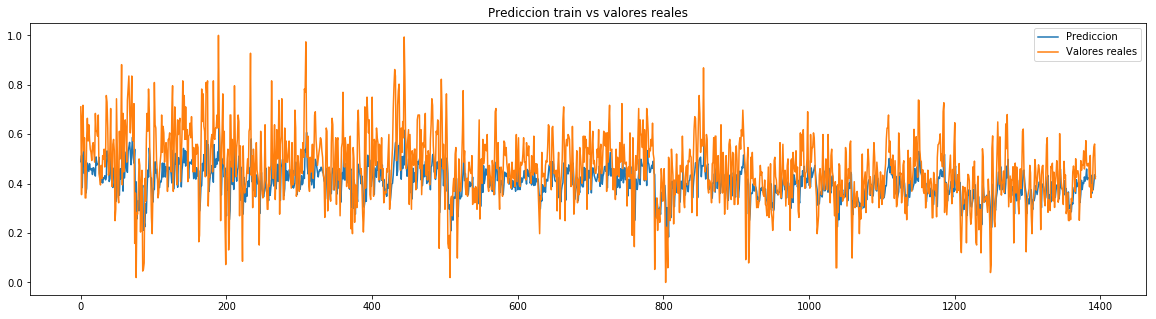

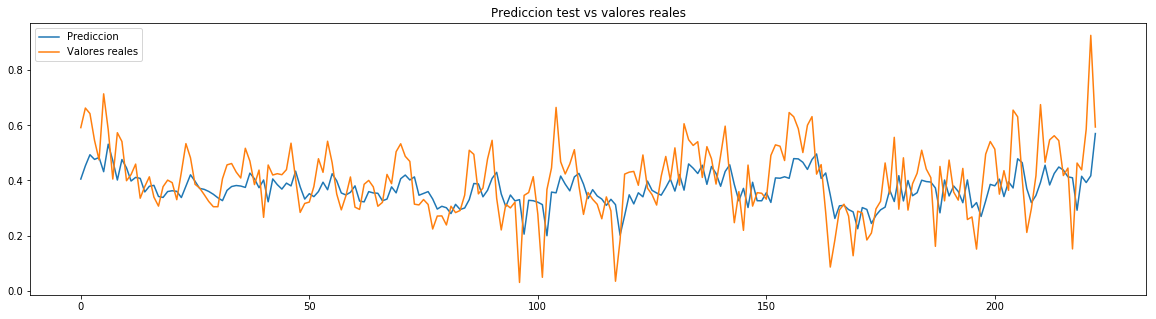

In [0]:
trainSlice = originalTrain[lag:]
testSlice = originalTest[lag:]


plt.figure(figsize=(20,5))
plt.plot(trainPredict_rnn[:,0], label="Prediccion")
plt.plot(trainSlice, label="Valores reales")
plt.title("Prediccion train vs valores reales")
plt.legend()


plt.figure(figsize=(20,5))
plt.plot(testPredict_rnn[:,0], label="Prediccion")
plt.plot(testSlice, label="Valores reales")
plt.title("Prediccion test vs valores reales")
plt.legend()

En el grafico del conjunto de entrenamiento es dificil distinguir como son las predicciones. En el de prueba, se puede ver que las predicciones siguen un patron similar a los valores reales, pero cometen bastantes errores, en particular con los valores extremos. 
Esto nos hace creer que el modelo realiza predicciones más conservadoras sobre los datos.  Lo que si es recalcable, que el modelo pued predecir de forma acertada el comportamiento de la concentración de O3, (las subidas y bajadas)

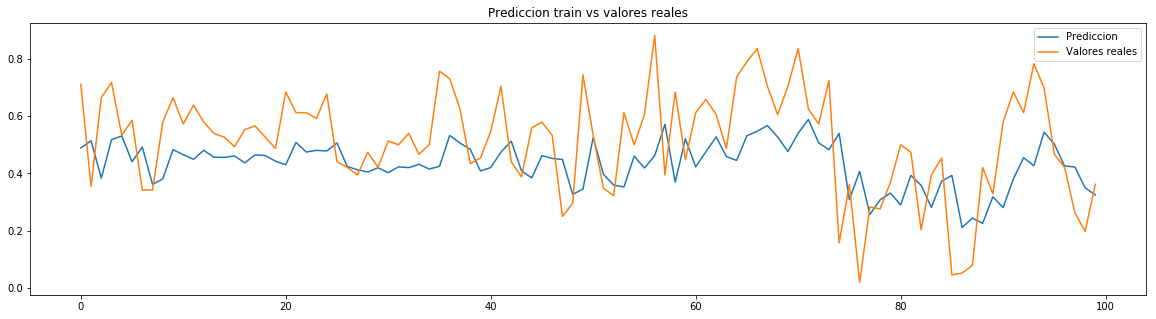

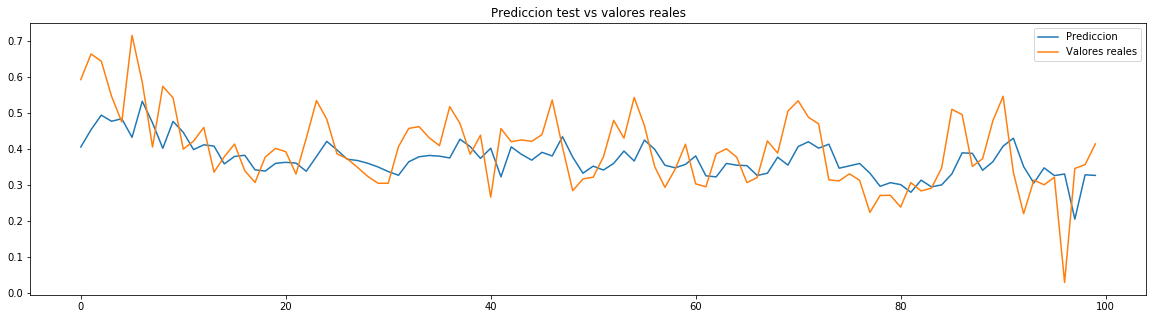

In [0]:
plt.figure(figsize=(20,5))
plt.plot(trainPredict_rnn[:100,0], label="Prediccion")
plt.plot(trainSlice[:100], label="Valores reales")
plt.title("Prediccion train vs valores reales")
plt.legend()


plt.figure(figsize=(20,5))
plt.plot(testPredict_rnn[:100,0], label="Prediccion")
plt.plot(testSlice[:100], label="Valores reales")
plt.title("Prediccion test vs valores reales")
plt.legend()

f) En lugar de aumentar el número de dimensiones como el el paso c), entrene la red con un *timestep=lag* y con dimensión de entrada = 1. Compare y comente sobre el cambio de dimensiones y número de parámetros de las redes ¿Cuál tipo de red tiene más parámetros y porqué? ¿Se produce una mejora del error de entrenamiento y pruebas? ¿Los tiempos de computación son comparables? Comente brevemente sobre cuál es la forma correcta para aprovechar la información a través del tiempo, si con esta forma o la realizada en el paso e).

In [0]:
testX_f = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX_f = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

In [0]:
model_rnn = train_rnn(trainX_f, trainY, (lag, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, 4)                 24        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1394/1394 [==============================] - 10s 7ms/step - loss: 0.0367
Epoch 2/25
1394/1394 [==============================] - 7s 5ms/step - loss: 0.0154
Epoch 3/25
1394/1394 [==============================] - 8s 5ms/step - loss: 0.0153
Epoch 4/25
1394/1394 [==============================] - 7s 5ms/step - loss: 0.0153
Epoch 5/25
1394/1394 [==============================] - 7s 5ms/step - loss: 0.0150
Epoch 6/25
1394/1394 [==============================] - 8s 5ms/step - loss: 0.0150
Epoch 7/25
1394/1394 [=====================

In [0]:
model_cnn = train_cnn(trainX_f, trainY, (lag,1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 6, 4)              8         
_________________________________________________________________
flatten_12 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 25        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1394/1394 [==============================] - 5s 4ms/step - loss: 0.0508
Epoch 2/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0164
Epoch 3/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0159
Epoch 4/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.0155
Epoch 5/25
1394/1394 [==============================] - 4s 3ms/step - loss: 0.

In [0]:
trainPredict_rnn = model_rnn.predict(trainX_f, batch_size=100)
trainPredict_rnn = mms.inverse_transform(trainPredict_rnn)
trainY_f = mms.inverse_transform(trainY.reshape(-1,1))

testPredict_rnn = model_rnn.predict(testX_f, batch_size=100)
testPredict_rnn = mms.inverse_transform(testPredict_rnn)
testY_f = mms.inverse_transform(testY.reshape(-1,1))

trainScore_rnn = math.sqrt(mean_squared_error(trainY_f, trainPredict_rnn[:,0]))
print('Train Score rnn: %.2f RMSE' % (trainScore_rnn))
testScore_rnn = math.sqrt(mean_squared_error(testY_f, testPredict_rnn[:,0]))
print('Test Score rnn: %.2f RMSE' % (testScore_rnn))

trainPredict_cnn = model_cnn.predict(trainX_f, batch_size=100)
trainPredict_cnn = mms.inverse_transform(trainPredict_cnn)
trainY_f = mms.inverse_transform(trainY.reshape(-1,1))

testPredict_cnn = model_rnn.predict(testX_f, batch_size=100)
testPredict_cnn = mms.inverse_transform(testPredict_cnn)
testY_f = mms.inverse_transform(testY.reshape(-1,1))

trainScore_cnn = math.sqrt(mean_squared_error(trainY_f, trainPredict_cnn[:,0]))
print('Train Score cnn: %.2f RMSE' % (trainScore_cnn))
testScore_cnn = math.sqrt(mean_squared_error(testY_f, testPredict_cnn[:,0]))
print('Test Score cnn: %.2f RMSE' % (testScore_cnn))

Train Score rnn: 0.11 RMSE
Test Score rnn: 0.10 RMSE
Train Score cnn: 0.11 RMSE
Test Score cnn: 0.10 RMSE


No se ve una mejora en el RMSE y los tiempos de ejecucion fueron mucho mayores. 

g) Compare el desempeño de ambos modelos al variar el *lag* definido en c), recuerde que puede variarlo entre 1 y $T_{max}$. Comente brevemente sobre qué resulta mejor, el tener más información para predecir o si ésto satura la predicción por el efecto del gradiente desvaneciente ¿Ésto ocurre sólo con el modelo recurrente o con el convolucional también? ¿Por qué?

In [0]:

def try_lags(lags, model_train):
    rmse_train = []
    rmse_val = []

    for lag in lags:
        print(lag, end=" ")
        trainX_c, testX_c, trainY_c, testY_c = train_test_sets(lag)
        testX_c = np.reshape(testX_c, (testX_c.shape[0], 1, testX_c.shape[1]))
        trainX_c = np.reshape(trainX_c, (trainX_c.shape[0], 1, trainX_c.shape[1]))

        model = model_train(trainX_c, trainY_c, (1,lag), 0)

        trainPredict = model.predict(trainX_c, batch_size=100)
        trainPredict = mms.inverse_transform(trainPredict)
        trainY_c = mms.inverse_transform(trainY_c.reshape(-1,1))

        testPredict = model.predict(testX_c, batch_size=100)
        testPredict = mms.inverse_transform(testPredict)
        testY_c = mms.inverse_transform(testY_c.reshape(-1,1))

        trainScore = math.sqrt(mean_squared_error(trainY_c, trainPredict[:,0]))
        testScore = math.sqrt(mean_squared_error(testY_c, testPredict[:,0]))

        rmse_train.append(trainScore)
        rmse_val.append(testScore)
        
    return rmse_train, rmse_val


In [0]:
lags = [i for i in range(1, 100, 5)]
rnn_train, rnn_val = try_lags(lags, train_rnn)

1 6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91 96 

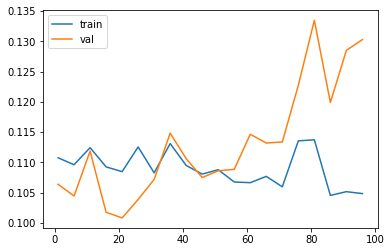

In [0]:
plt.plot(lags, rnn_train, label="train")
plt.plot(lags, rnn_val, label="val")
plt.legend()


Por lo que se ve en el grafico, usar un lag demasiado alto si parece llevar a overfitting. El modelo entrega predicciones menos suaves.

In [0]:
cnn_train, cnn_val = try_lags(lags, train_cnn)

1 6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91 96 

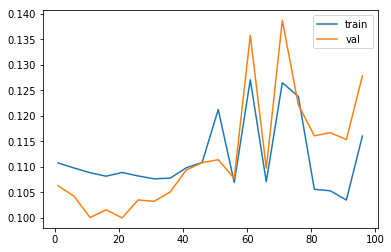

In [0]:
plt.plot(lags, cnn_train, label="train")
plt.plot(lags, cnn_val, label="val")
plt.legend()

El efecto de overfitting con mayores valores tambien pasa con la red convolucional.

Más no es siempre mejor, en particular al regular un parámetro es mejor tener un conjunto suficientemente grande datos de calidad, a tener uno inmenso que no entregue información relevante, o que repita información.
El problema de overfitting es transversal a los modelos que se usen.
Quizas para la CNN si se usaran un modelo con dropout entre capas se podría compatir este problema.

h) Como habrá notado, si usa una ventana de tiempo/*timesteps* muy larga ($T$ grande), las redes tienen dificultades para aprender. Para abordar este problema se le pide experimentar con la siguiente idea: dividir una secuencia de largo $T$ en trozos de largo $K$ y representarla como una matriz de $T/K$ columnas (asumamos que $T$ es un múltiplo de $K$) y $K$ filas, y entrenar la red para procesar la secuencia formada las columnas de esa matriz. De este modo, la red debe aprender dependencias temporales más cortas (largo $T/K$ en vez de $T$), pero accede a toda la información original en forma de atributos ($K$). Llamaremos a esta idea “**time folding**”. Se le recomienda usar un valor de $K$ que tenga sentido en el problema (por ejemplo $K=7$ representaría una semana). Defina y entrene los modelos para ésta nueva representación.  
¿Cómo se ven afectados los modelos?

In [17]:
trainX_h, testX_h, trainY_h, testY_h = train_test_sets(140)

K = 7
nCols = int(140/K)
folded_train = []
for x in trainX_h: 
    matrix = np.array([np.array(x[i:i+K]) for i in range(nCols)]).transpose()
    folded_train.append(matrix)
    
folded_train = np.array(folded_train)
folded_train.shape

(1260, 7, 20)

In [18]:
model_rnn = train_rnn(folded_train, trainY_h, (7, 20))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 4)                 100       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1260/1260 [==============================] - 7s 6ms/step - loss: 0.0294
Epoch 2/25
1260/1260 [==============================] - 7s 6ms/step - loss: 0.0190
Epoch 3/25
1260/1260 [==============================] - 8s 6ms/step - loss: 0.0182
Epoch 4/25
1260/1260 [==============================] - 9s 7ms/step - loss: 0.0178
Epoch 5/25
1260/1260 [==============================] - 8s 6ms/step - loss: 0.0177
Epoch 6/25
1260/1260 [==============================] - 7s 6ms/step - loss: 0.0176
Epoch 7/25
1260/1260 [====================

In [19]:
model_cnn = train_cnn(folded_train, trainY_h, (7, 20))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 4)                 100       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1260/1260 [==============================] - 4s 3ms/step - loss: 0.0371
Epoch 2/25
1260/1260 [==============================] - 4s 3ms/step - loss: 0.0219
Epoch 3/25
1260/1260 [==============================] - 4s 3ms/step - loss: 0.0195
Epoch 4/25
1260/1260 [==============================] - 3s 3ms/step - loss: 0.0188
Epoch 5/25
1260/1260 [==============================] - 3s 3ms/step - loss: 0.0180
Epoch 6/25
1260/1260 [==============================] - 3s 3ms/step - loss: 0.0177
Epoch 7/25
1260/1260 [====================

Aumentan la cantidad de parámetros a entrenar por un lado, y por el otro la estructura de matriz de los nuevo datos le puede dar una indormación erronea al modelo, si es que este empieza a aprender las predicciones con un componente ciclico que no sabes si está así.

k) Agregue las otras mediciones como nuevos valores de entrada al modelo definido en f), por lo que ahora se transforma la serie de tiempo a N-Dimensional, se tiene un *timestep=lag* con un *features*= mediciones nuevas + Ozono. Defina los nuevos modelos con el mejor *lag* encontrado en g).

l) Entrene los modelos  ¿Se observan los mismos resultados? ¿Las mediciones incorporadas como información adicional ayudan al modelo? Comente y compare.